In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from os.path import join
from scipy.stats import truncnorm
import seaborn as sns
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from ili.utils.distributions_pt import IndependentTruncatedNormal

from toolbox.distributions import TailedNormal, IndependentTailedNormal
from toolbox.simulators import syren_simulator, sample_uniform_lhs

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
sns.set(style="whitegrid", context="paper")


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Device: cpu


## STEP 1 - Generate Training Data and Setup Optuna Studies

In [2]:
# Fixed
L, N = 1000, 128
kf = 2*np.pi/L
knyq = np.pi*N/L
kedges = np.arange(0, knyq, kf)
kcenters = (kedges[:-1] + kedges[1:])/2
a = 1.0

In [3]:
n_simulations = 10000

# Parameter ranges [Om, h]
param_1_range = (0.24, 0.40)   # Om
param_2_range = (0.61, 0.73)    # h
param_ranges = [param_1_range, param_2_range]

param_1_width = param_1_range[1] - param_1_range[0]
param_2_width = param_2_range[1] - param_2_range[0]

# Scale sigma relative to parameter ranges
sigma_scale = 0.1
sigmas = [sigma_scale * (high - low) for low, high in param_ranges]

# Prior
prior = ili.utils.IndependentNormal(
    loc=[param_1_range[0] + param_1_width/2,
         param_2_range[0] + param_2_width/2],
    scale=sigmas,
    device=device
)

# Create proposal distributions
proposal_old = ili.utils.Uniform(
    low=[param_1_range[0], param_2_range[0]],
    high=[param_1_range[1], param_2_range[1]],
    device=device
)

proposal_new = TailedNormal(
    a=torch.tensor([param_1_range[0], param_2_range[0]], dtype=torch.float32),
    b=torch.tensor([param_1_range[1], param_2_range[1]], dtype=torch.float32),
    sigma=torch.tensor([sigmas[0], sigmas[1]], dtype=torch.float32),
)

In [4]:
# Sample from proposals
theta_uniform = sample_uniform_lhs(
    n_samples=n_simulations, param_ranges=param_ranges)
theta_tailed = proposal_new.sample_lhs(n_simulations)

# Run simulations
x_uniform = np.array([syren_simulator(theta_uniform[i].numpy(), L=L, N=N, a=a)
                      for i in range(n_simulations)])
x_tailed = np.array([syren_simulator(theta_tailed[i].numpy(), L=L, N=N, a=a)
                     for i in range(n_simulations)])

print("Uniform proposal parameter range: \n"
      f"\tOm={theta_uniform[:, 0].min():.3f}-{theta_uniform[:, 0].max():.3f},\n"
      f"\th={theta_uniform[:, 1].min():.3f}-{theta_uniform[:, 1].max():.3f}")
print("TailedNormal proposal parameter range: \n"
      f"\tOm={theta_tailed[:, 0].min():.3f}-{theta_tailed[:, 0].max():.3f},\n"
      f"\th={theta_tailed[:, 1].min():.3f}-{theta_tailed[:, 1].max():.3f}")

Uniform proposal parameter range: 
	Om=0.240-0.400,
	h=0.610-0.730
TailedNormal proposal parameter range: 
	Om=0.182-0.462,
	h=0.565-0.772


Saved plot: sci-2-dim-figures/example-samples.png


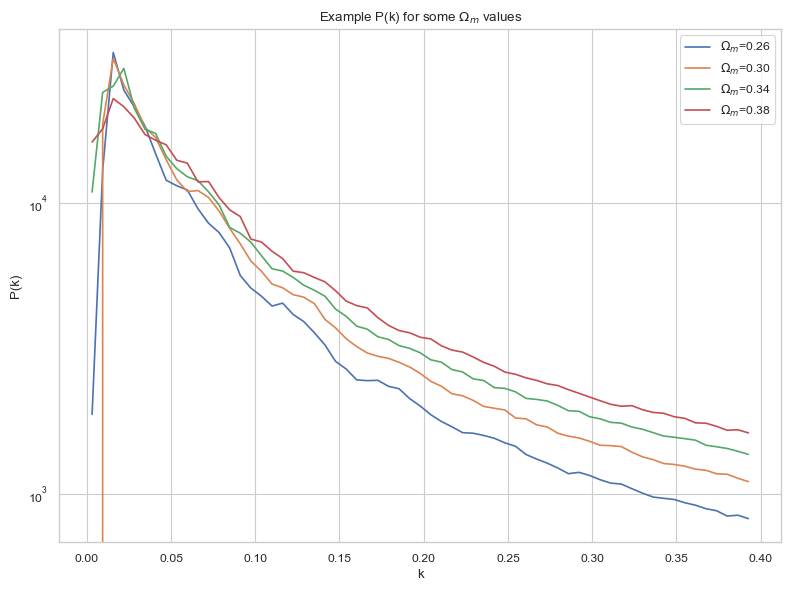

In [ ]:
# Plot example simulations
omega_m_values = [0.26, 0.30, 0.34, 0.38]
h_fixed = 0.7

plt.figure(figsize=(8, 6))
for Om in omega_m_values:
    pk = syren_simulator([Om, h_fixed], L=L, N=N, a=a)
    plt.plot(kcenters, pk, label=f'$\Omega_m$={Om:.2f}')

plt.semilogy()
plt.xlabel('k')
plt.ylabel('P(k)')
plt.title('Example P(k) for some $\Omega_m$ values')
plt.legend()
plt.tight_layout()
os.makedirs('sci-2-dim-figures', exist_ok=True)
filename = f'sci-2-dim-figures/example-samples.png'
# plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()

Saved plot: sci-2-dim-figures/parameter-space.png


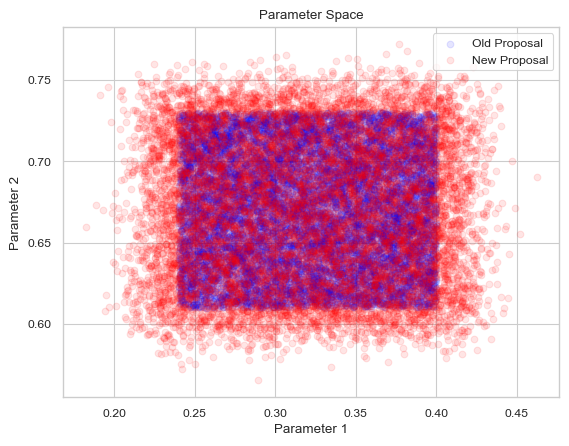

In [ ]:
plt.scatter(theta_uniform[:, 0].cpu(), theta_uniform[:, 1].cpu(),
            c='blue', label='Old Proposal', alpha=0.1)
plt.scatter(theta_tailed[:, 0].cpu(), theta_tailed[:, 1].cpu(),
            c='red', label='New Proposal', alpha=0.1)
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.title('Parameter Space')
plt.legend()

filename = f'sci-2-dim-figures/parameter-space.png'
# plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot: {filename}")

Saved plot: sci-2-dim-figures/parameter-space-posterior.png


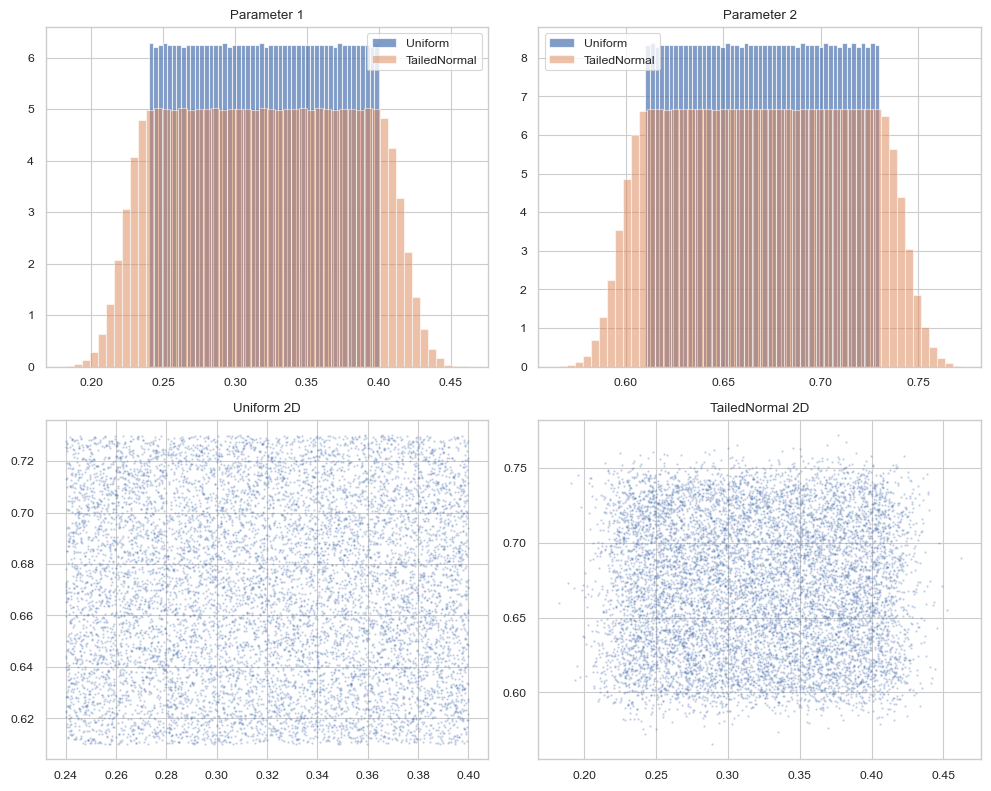

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Parameter 1
axes[0, 0].hist(theta_uniform[:, 0], bins=50, alpha=0.7,
                label='Uniform', density=True)
axes[0, 0].hist(theta_tailed[:, 0], bins=50, alpha=0.5,
                label='TailedNormal', density=True)
axes[0, 0].set_title('Parameter 1')
axes[0, 0].legend()

# Parameter 2
axes[0, 1].hist(theta_uniform[:, 1], bins=50, alpha=0.7,
                label='Uniform', density=True)
axes[0, 1].hist(theta_tailed[:, 1], bins=50, alpha=0.5,
                label='TailedNormal', density=True)
axes[0, 1].set_title('Parameter 2')
axes[0, 1].legend()

# 2D scatter plots
axes[1, 0].scatter(theta_uniform[:, 0], theta_uniform[:, 1], alpha=0.2, s=1)
axes[1, 0].set_title('Uniform 2D')

axes[1, 1].scatter(theta_tailed[:, 0], theta_tailed[:, 1], alpha=0.2, s=1)
axes[1, 1].set_title('TailedNormal 2D')

plt.tight_layout()

filename = f'sci-2-dim-figures/parameter-space-posterior.png'
# plt.savefig(filename, bbox_inches='tight')
print(f"Saved plot: {filename}")

In [9]:
import optuna

# SAVE THE DATA AND CREATE OPTUNA STUDIES
model_library = './sci-2-dim-models'
os.makedirs(model_library, exist_ok=True)


def setup_optuna(exp_path, name, n_startup_trials):
    sampler = optuna.samplers.TPESampler(
        n_startup_trials=n_startup_trials,
        multivariate=True,
        constant_liar=True,
    )
    study = optuna.create_study(
        sampler=sampler,
        direction="maximize",
        storage='sqlite:///'+join(exp_path, 'optuna_study.db'),
        study_name=name,
        load_if_exists=True
    )
    return study


# Uniform NPE
model_dir = join(model_library, 'uniform_power')
os.makedirs(model_dir, exist_ok=True)
np.save(join(model_dir, 'theta.npy'), theta_uniform.numpy())
np.save(join(model_dir, 'x.npy'), x_uniform)
setup_optuna(model_dir, 'uniform_power', n_startup_trials=30)

# TailedUniform NPE
model_dir = join(model_library, 'tailed_power')
os.makedirs(model_dir, exist_ok=True)
np.save(join(model_dir, 'theta.npy'), theta_tailed.numpy())
np.save(join(model_dir, 'x.npy'), x_tailed)
setup_optuna(model_dir, 'tailed_power', n_startup_trials=30)

[I 2025-11-04 13:22:37,822] A new study created in RDB with name: uniform_power
[I 2025-11-04 13:22:37,854] A new study created in RDB with name: tailed_power


## Step 2 - Run Optuna Experiments

In [ ]:
# Create dataloaders
loader_old = NumpyLoader(x=x_uniform, theta=theta_uniform)
loader = NumpyLoader(x=x_tailed, theta=theta_tailed)

# Instantiate neural networks for ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf',
                           hidden_features=16, num_transforms=5,),
    ili.utils.load_nde_sbi(engine='NPE', model='made',
                           hidden_features=16, num_transforms=5)
]

nets_nle = [
    ili.utils.load_nde_sbi(engine='NLE', model='maf',
                           hidden_features=16, num_transforms=5,),
    ili.utils.load_nde_sbi(engine='NLE', model='made',
                           hidden_features=16, num_transforms=5)
]

# Define training arguments
train_args = {
    'training_batch_size': 64,
    'learning_rate': 5e-5
}

os.makedirs('sci-2-dim-models', exist_ok=True)

# Initialize the trainers
runner_old = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=proposal_old,
    out_dir='sci-2-dim-models/uniform_power'
)

runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=proposal_new,
    out_dir='sci-2-dim-models/tailed_power'
)

runner_nle = InferenceRunner.load(
    backend='sbi',
    engine='NLE',
    prior=prior,  # Use the same prior
    nets=nets_nle,
    device=device,
    train_args=train_args,
    proposal=proposal_old,
    out_dir='sci-2-dim-models/nle_power'
)

In [13]:
posterior_ensemble_old, summaries_old = runner_old(loader=loader_old)

INFO:root:MODEL INFERENCE CLASS: NPE
/opt/homebrew/anaconda3/envs/ili-temp/lib/python3.10/site-packages/sbi/inference/trainers/npe/npe_base.py:186: UserWarning: The proposal you passed is neither the prior nor a `NeuralPosterior` object. If you are an expert user and did so for research purposes, this is fine. If not, you might be doing something wrong: feel free to create an issue on Github.
  self._check_proposal(proposal)
INFO:root:Training model 1 / 2.


Using SNPE-C with atomic loss
Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 34

KeyboardInterrupt: 

In [ ]:
posterior_ensemble, summaries = runner(loader=loader)

In [12]:
posterior_ensemble_nle, summaries_nle = runner_nle(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NLE
INFO:root:Training model 1 / 2.


 Training neural network. Epochs trained: 305

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 343306 epochs.

INFO:root:It took 1112.6914949417114 seconds to train models.
INFO:root:Saving model to sci-2-dim-models/nle_power


 Neural network successfully converged after 344 epochs.

Saved plot: sci-2-dim-figures/train-and-val.png


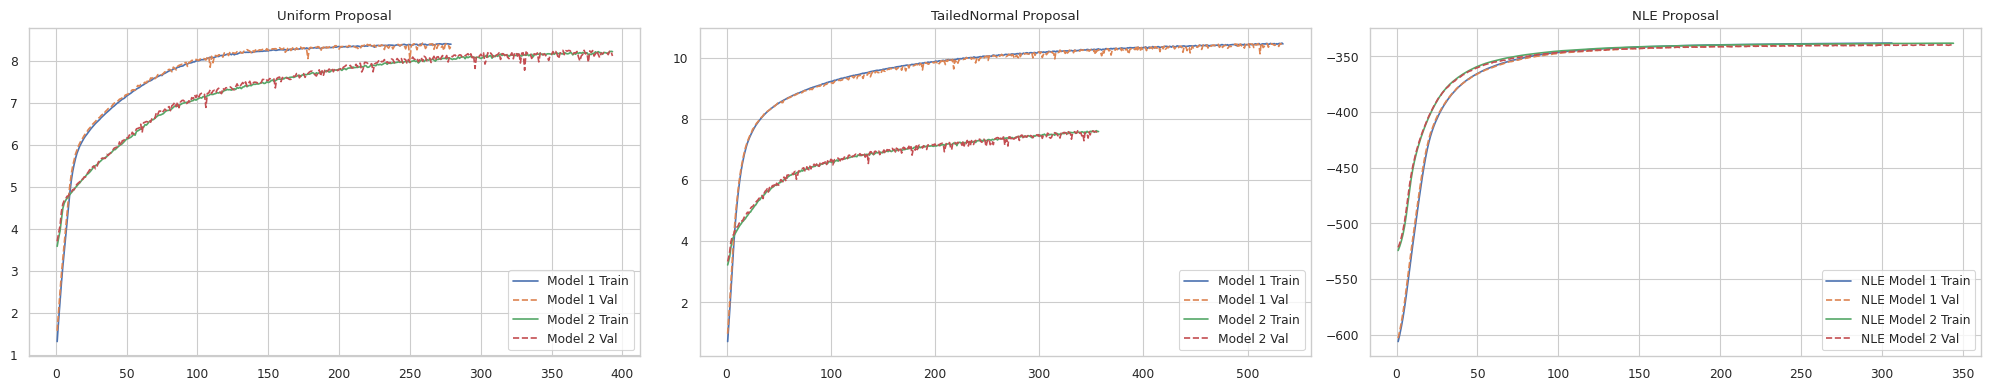

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))

# Uniform proposal
for i, summary in enumerate(summaries_old):
    train_logprob = -1.0 * np.array(summary['training_loss'])
    val_logprob = -1.0 * np.array(summary['validation_loss'])
    epochs = np.arange(1, len(train_logprob) + 1)
    axes[0].plot(epochs, train_logprob, label=f"Model {i+1} Train")
    axes[0].plot(epochs, val_logprob, '--', label=f"Model {i+1} Val")
axes[0].set_title('Uniform Proposal')
axes[0].legend()

# TailedNormal proposal
for i, summary in enumerate(summaries):
    train_logprob = -1.0 * np.array(summary['training_loss'])
    val_logprob = -1.0 * np.array(summary['validation_loss'])
    epochs = np.arange(1, len(train_logprob) + 1)
    axes[1].plot(epochs, train_logprob, label=f"Model {i+1} Train")
    axes[1].plot(epochs, val_logprob, '--', label=f"Model {i+1} Val")
axes[1].set_title('TailedNormal Proposal')
axes[1].legend()

# NLE proposal

for i, summary in enumerate(summaries_nle):
    train_logprob = -1.0 * np.array(summary['training_loss'])
    val_logprob = -1.0 * np.array(summary['validation_loss'])
    epochs = np.arange(1, len(train_logprob) + 1)
    axes[2].plot(epochs, train_logprob, label=f"NLE Model {i+1} Train")
    axes[2].plot(epochs, val_logprob, '--', label=f"NLE Model {i+1} Val")
axes[2].set_title('NLE Proposal')
axes[2].legend()
plt.tight_layout()
filename = f'sci-2-dim-figures/train-and-val.png'
# plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()

Running vectorized MCMC with 20 chains: 100%|█████████▉| 23600/23700 [01:25<00:00, 277.49it/s]


Saved plot: sci-2-dim-figures/histogram.png


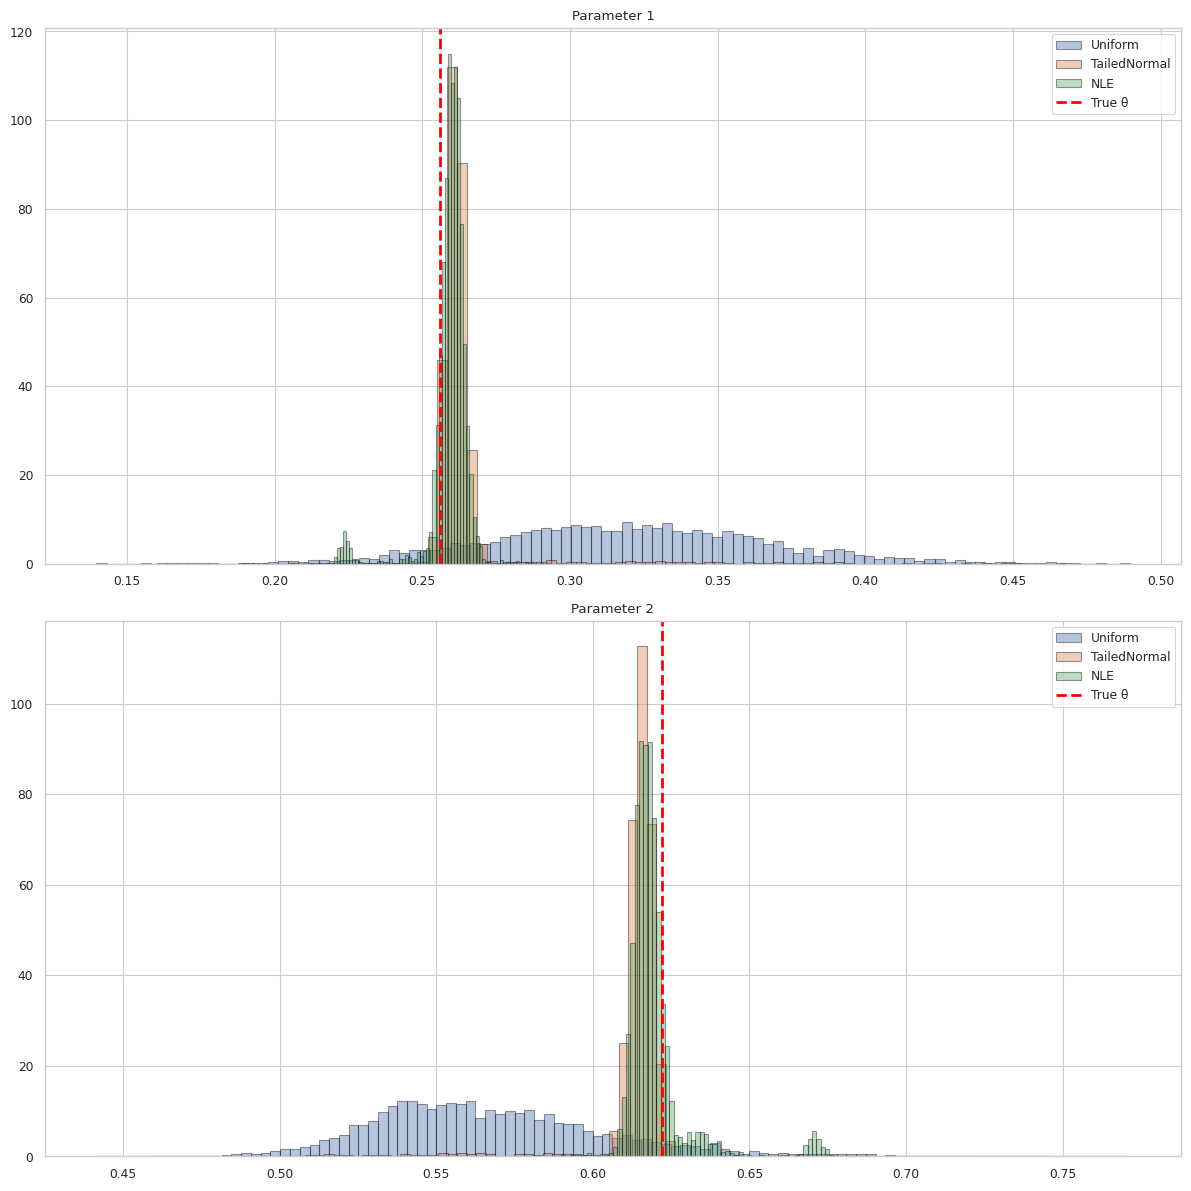

In [17]:
theta_true_edge = np.array([
    param_1_range[0] + 0.1 * param_1_width,
    param_2_range[0] + 0.1 * param_2_width
])

n_posterior_samples = 1000
x_obs_edge = simulator(theta_true_edge)

samples_uniform = posterior_ensemble_old.sample(
    (n_posterior_samples,), x_obs_edge).cpu().numpy()
samples_tailed = posterior_ensemble.sample(
    (n_posterior_samples,), x_obs_edge).cpu().numpy()
samples_nle = posterior_ensemble_nle.sample(
    (n_posterior_samples,), x_obs_edge,
    method='slice_np_vectorized', num_chains=20
).detach().cpu().numpy()

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

methods = ['Uniform', 'TailedNormal', 'NLE']
samples_list = [samples_uniform, samples_tailed, samples_nle]

for i, param in enumerate(['Parameter 1', 'Parameter 2']):
    for method, samples in zip(methods, samples_list):
        axes[i].hist(samples[:, i], bins=100, alpha=0.4,
                     density=True, label=method, edgecolor='black')
    axes[i].axvline(theta_true_edge[i], color='red',
                    linestyle='--', linewidth=2, label='True θ')
    axes[i].set_title(f'{param}')
    axes[i].legend()

plt.tight_layout()
os.makedirs('sci-2-dim-figures', exist_ok=True)
filename = f'sci-2-dim-figures/histogram.png'
plt.savefig(filename, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()